<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/notebooks/PSF_Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installs**

In [ ]:
!pip install photutils --quiet

In [ ]:
!pip install poppy --quiet

Run above cells and restart runtime. Continue to run the cells below.

# **Imports**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb


import yaml
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import gaussian_fwhm_to_sigma, gaussian_sigma_to_fwhm
from astropy.modeling import models, fitting
from astropy.visualization import LogStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits
from astropy.convolution import Gaussian2DKernel, convolve
from scipy.signal import fftconvolve
from astropy.table import Table

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from matplotlib import colors as col
from astropy.wcs import WCS

from photutils import aperture as aper
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAperture

from scipy.stats import norm

import os
from time import perf_counter
import json
import requests

import poppy as poy
import astropy.units as u

# get the WSID and password if not already defined
if not os.environ.get('CASJOBS_USERID'):
    os.environ['CASJOBS_USERID'] = "avinashck90"
if not os.environ.get('CASJOBS_PW'):
    os.environ['CASJOBS_PW'] = "INSIST369"

sb.set_style('dark')
matplotlib.rcParams['font.size']=12
matplotlib.rcParams['figure.figsize']=(10,10)

In [ ]:
# Minimalistic seaborn style
sb.set_theme(style="white")
import matplotlib as mpl

mpl.rcParams.update({
   # "text.usetex": False,                # If using LaTeX for labels
   # "font.family": "serif",
   # "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 25,
    "font.size": 25,
    "legend.fontsize": 10,
    "xtick.labelsize": 30,
    "ytick.labelsize": 30,
    "axes.titlesize": 30,
    "lines.linewidth": 1.0,
    "lines.markersize": 3,
    "figure.dpi": 300,                  # High-quality output
    "savefig.dpi": 300,
    "axes.grid": False,                 # Avoid grids unless needed
    "legend.frameon": False             # No legend frame
})

plt.rcParams['axes.titlesize'] = plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 30


# **GitHub**

In [ ]:
!git clone https://github.com/Jack3690/INSIST/ --quiet

In [ ]:
cd /content/INSIST/data

# **Simple PSF Generator**

In [ ]:
fwhm_in = float(input("Enter FWHM of source in arcsecond : ") or "0.3")
ABmag   = float(input("Enter AB magnitude of the source  : ") or "0")

# Flux to AB magnitude
flux = 3631*pow(10,-ABmag/2.5)

pixel_scale = 0.01 #arcsecond

# Input FWHM to detector fwhm conversion
fwhm = fwhm_in/pixel_scale

# fwhm to sigma conversion
sigma_psf = fwhm*gaussian_fwhm_to_sigma


# Number of pixels.
n_pix = 512
y, x  = np.mgrid[0:(n_pix), 0:(n_pix)]

# Modelling a 2D gaussian at the center of the image.
model_gauss = models.Gaussian2D(1, len(x)//2, len(x)//2, sigma_psf, sigma_psf)

# Modelling a Airy Disk of same amplitude.
model_airy = models.AiryDisk2D(1, len(x)//2, len(x)//2, fwhm)

image_g = flux*model_gauss(x,y)/model_gauss(x,y).sum()

image_a = flux*model_airy(x,y)/model_airy(x,y).sum()

# Plot
fix, ax = plt.subplots(1,2,figsize=(20,10))

norm = ImageNormalize(stretch=LogStretch())

ax[0].imshow(np.log10(1+image_g/image_g.max()),origin='lower',cmap='Greys',vmin=1e-11)
ax[0].set_title(f'Gaussian Model, ABmag = {ABmag}')

ax[1].imshow(image_a,origin='lower',cmap='Greys',norm=norm)
ax[1].set_title(f'Airy Model, ABmag = {ABmag}');

In [ ]:
image_g.sum(), flux, image_a.sum()

Airy Disk not modelled properly yet

# **PSF Simulation using POPPY**

## **On Axis**

In [ ]:
d = 100
r1 = d/2
r2 = (18/50)*r1
r2

In [ ]:


# On axis Aperture
pri = poy.CircularAperture(radius=r1*u.cm)
sec     = poy.SecondaryObscuration(secondary_radius = r2*u.cm,
                                        support_width = 2.5*u.cm,
               support_angle_offset = 0)

osys = poy.OpticalSystem(oversample = 10, npix = 2000)
atlast = poy.CompoundAnalyticOptic( opticslist=[pri, sec], name='On Axis')
osys.add_pupil(atlast)


"""
ap1 = poy.SquareAperture(size = 1*u.m)
ap2 = poy.SecondaryObscuration(secondary_radius = 1*u.cm,
                                        support_width = 2.5*u.cm,
               support_angle_offset = 0)

atlast = poy.CompoundAnalyticOptic( opticslist=[ap1, ap2 ], name='MOS Mirrorlets')
#osys.add_pupil(atlast)
"""

# Detector


osys.add_detector(pixelscale=0.1, fov_arcsec=40.1)
osys.display(colorbar_orientation='vertical')

In [ ]:
psfs = 0
for wav in np.arange(150,301,10):
  psf = osys.calc_psf(wav*1e-9)
  psfs += psf[0].data

psf[0].data = psfs/psfs.max()

In [ ]:
fig,ax = plt.subplots(figsize=(13,10))
osys.display(ax=ax, colorbar_orientation='vertical')

In [ ]:
poy.display_psf(psf, title = 'Broadband PSF')
plt.grid(False)

In [ ]:
fwhm_in     = 0.2  # arcsecs
pixel_scale = 0.01  # arcseconds/pixels
FWHM        = fwhm_in/pixel_scale
sigma       = FWHM*gaussian_fwhm_to_sigma
sigma

on_axis = psfs/psfs.max()
kernel = Gaussian2DKernel(sigma,sigma,x_size=69,y_size=69)
kernel.normalize()

conv_on =  fftconvolve(on_axis, kernel, mode = 'same')
conv_on_binned = conv_on.reshape(401, 10, 401,10).sum(axis=(1,3))

In [ ]:
fig, ax = plt.subplots( figsize = (13,10))
ax.set_title("PSF On Axis")

img = ax.imshow(on_axis, cmap="jet",norm='log')
cb  = plt.colorbar(img, ax=ax)
cb.set_label('log(Intensity)')
ax.set_xlabel('x [pix]')
ax.set_ylabel('y [pix]')
fig.savefig('on_axis_psf.png', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (15,15))
ax[0,0].set_title("Poppy_ON")

ax[0,0].imshow(on_axis, cmap="jet",norm=col.LogNorm())

ax[0,1].set_title("Kernel")
ax[0,1].imshow(kernel, cmap="jet")

ax[1,0].set_title("convolve_on")
im_on = ax[1,0].imshow(conv_on, cmap="jet",norm=col.LogNorm())

im_on = ax[1,1].imshow(conv_on_binned, cmap="jet",norm=col.LogNorm())
plt.colorbar(im_on,shrink=0.9)

In [ ]:
np.save(f'on_axis_poppy_{int(d)}.npy', conv_on_binned/conv_on_binned.sum())

In [ ]:
np.save(f'on_axis_poppy_{int(d)}_oversamp_10.npy', conv_on/conv_on.sum())

In [ ]:
z = conv_on_binned[150:250,150:250]
x = np.linspace(-50,50,100)

yy,xx = np.meshgrid(x,x)
init = models.Gaussian2D()
fit = fitting.LevMarLSQFitter()
model = fit(init, xx, yy,z)

In [ ]:
std = np.mean([model.x_stddev.value, model.y_stddev.value])
std*gaussian_sigma_to_fwhm

## **On Axis Tangential**

In [ ]:
d = 80
r1 = d/2
r2 = (18/50)*r1
r2

In [ ]:
osys = poy.OpticalSystem(oversample = 10, npix = 2000)

# On axis Aperture
osys.add_pupil(poy.CircularAperture(radius=r1*u.cm))

s = (r2 - 1.25)/100
osys.add_pupil(poy.AsymmetricSecondaryObscuration(secondary_radius = r2*u.cm,
                                                  support_offset_x=[s,0,-s,0],
                                                  support_offset_y=[0,s,0,-s],
                                        support_width = 2.5*u.cm,
               support_angle = [0,90,180,270]))

# Detector
osys.add_detector(pixelscale=0.1, fov_arcsec=40.1)

osys.display()

In [ ]:
psfs = 0
for wav in np.arange(150,301,10):
  psf = osys.calc_psf(wav*1e-9)
  psfs += psf[0].data

psf[0].data = psfs/psfs.max()

In [ ]:
poy.display_psf(psf, title = 'Broadband PSF')
plt.grid(False)

In [ ]:
fwhm_in     = 0.2  # arcsecs
pixel_scale = 0.01  # arcseconds/pixels
FWHM        = fwhm_in/pixel_scale
sigma       = FWHM*gaussian_fwhm_to_sigma
sigma

on_axis = psfs/psfs.max()
kernel = Gaussian2DKernel(sigma,sigma,x_size=69,y_size=69)
kernel.normalize()

conv_on =  fftconvolve(on_axis, kernel, mode = 'same')
conv_on_binned = conv_on.reshape(401, 10, 401,10).sum(axis=(1,3))

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (15,15))
ax[0,0].set_title("Poppy_ON")

ax[0,0].imshow(on_axis, cmap="jet",norm=col.LogNorm())

ax[0,1].set_title("Kernel")
ax[0,1].imshow(kernel, cmap="jet")

ax[1,0].set_title("convolve_on")
im_on = ax[1,0].imshow(conv_on, cmap="jet",norm=col.LogNorm())

im_on = ax[1,1].imshow(conv_on_binned, cmap="jet",norm=col.LogNorm())
plt.colorbar(im_on,shrink=0.9)

In [ ]:
np.save(f'/content/on_axis_poppy_{int(d)}t.npy', conv_on_binned/conv_on_binned.sum())

In [ ]:
z = conv_on_binned[150:250,150:250]
x = np.linspace(-50,50,100)

yy,xx = np.meshgrid(x,x)
init = models.Gaussian2D()
fit = fitting.LevMarLSQFitter()
model = fit(init, xx, yy,z)

In [ ]:
std = np.mean([model.x_stddev.value, model.y_stddev.value])
std*gaussian_sigma_to_fwhm

## **Off Axis**

In [ ]:
d = 80
r1 = d/2

In [ ]:
osys = poy.OpticalSystem(oversample = 10, npix = 2000)

# On axis Aperture
osys.add_pupil(poy.CircularAperture(radius=r1*u.cm))

# Detector
osys.add_detector(pixelscale=0.1, fov_arcsec=40.1)
osys.display()

In [ ]:
psfs = 0
for wav in np.arange(150,300,10):
  psf = osys.calc_psf(wav*1e-9)
  psfs += psf[0].data

psf[0].data = psfs/psfs.sum()

In [ ]:
poy.display_psf(psf, title = 'Broadband PSF')
plt.grid(False)

In [ ]:
fwhm_in     = 0.2  # arcsecs
pixel_scale = 0.01  # arcseconds/pixels
FWHM        = fwhm_in/pixel_scale
sigma       = FWHM*gaussian_fwhm_to_sigma
sigma

off_axis = psfs/psfs.sum()
kernel = Gaussian2DKernel(sigma,sigma)
kernel.normalize()

conv_off =  fftconvolve(off_axis, kernel, mode = 'same')
conv_off_binned = conv_off.reshape(401, 10, 401,10).sum(axis=(1,3))

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (15,15))
ax[0,0].set_title("Poppy_ON")

ax[0,0].imshow(off_axis, cmap="jet",norm=col.LogNorm())

ax[0,1].set_title("Kernel")
ax[0,1].imshow(kernel, cmap="jet")

ax[1,0].set_title("convolve_on")
im_on = ax[1,0].imshow(conv_off, cmap="jet",norm=col.LogNorm())

im_on = ax[1,1].imshow(conv_off_binned, cmap="jet",norm=col.LogNorm())
plt.colorbar(im_on,shrink=0.9)

In [ ]:
np.save('off_axis_poppy.npy', conv_off_binned/conv_off_binned.sum())

In [ ]:
init = models.Gaussian1D(amplitude=0.04,mean=2005)
fit = fitting.LevMarLSQFitter()
x = np.linspace(0, 4010, 4010)
model = fit(init, x, conv_off[:,2005])

plt.plot(conv_off[:,2005])
plt.plot(model(x))
plt.xlim([1950,2060])
plt.legend(['Data','Model'])

In [ ]:
model.stddev.value*gaussian_sigma_to_fwhm

## **TMT**


In [ ]:
seg=[ 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62,
 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,
 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101,

 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197,
 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213,

 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229,
 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,
 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261,
 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277,
 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293,
 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309,

 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325,
 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341,
 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357,
 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373,
 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389,
 390, 391, 392, 393, 394, 395, 396,

      398, 399, 400, 401, 402, 403, 404, 405,  406, 407, 408,

      410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420,

      422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432,

      434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444,

      446,  447, 448, 449, 450, 451, 452, 453, 454, 455, 456,

      458,  459,  460, 461, 462, 463, 464, 465, 466, 467, 468,

      473, 474, 475, 476, 477,  478,

      486, 487, 488, 489, 490, 491,

      499, 500,501, 502, 503, 504,

      512,513, 514, 515, 516, 517,

      525, 526, 527, 528, 529, 530,

      538, 539, 540, 541, 542, 543]

In [ ]:
pri = poy.HexSegmentedDeformableMirror(rings=13, flattoflat=1.44*(np.sqrt(3)/2), gap=2.5e-3, center= False,
                                       segmentlist=seg)
sec = poy.SecondaryObscuration(secondary_radius=3.1, n_supports=6, support_width=0.1)
atlast = poy.CompoundAnalyticOptic(opticslist=[pri, sec], name='Thirty Metre Telescope')

In [ ]:
atlast.pupil_diam

In [ ]:
atlast.display(npix=2048, colorbar_orientation='vertical')

In [ ]:
osys = poy.OpticalSystem()
osys.add_pupil(atlast)
osys.add_detector(pixelscale=0.004, fov_arcsec=3, oversample=10)
psf = osys.calc_psf(0.84e-6)[0].data

In [ ]:
psfs = 0
for wav in np.linspace(840,2400,20):
  psf = osys.calc_psf(wav*1e-9)
  psfs += psf[0].data

psf[0].data = psfs/psfs.sum()

In [ ]:
poy.display_psf(psf, title = 'TMT Broadband PSF (Oversample=10)'
                , vmin=1e-10)
plt.grid(False)

In [ ]:
norm = simple_norm(psf[0].data, 'log', min_percent=1, max_percent=99)

plt.imshow(psf[0].data, cmap='jet', norm=norm)

# **ELT**

In [ ]:
from matplotlib.patches import RegularPolygon

In [ ]:
seg= np.array( list(np.arange(61,927)))# list(np.arange(91-5*6,91,5)) +

In [ ]:
pri = poy.HexSegmentedDeformableMirror(rings=20, flattoflat=1.45,
                                       gap=2.5e-3, center= False, segmentlist=seg)
sec = poy.SecondaryObscuration(secondary_radius=3.1, n_supports=6, support_width=0.1)
atlast = poy.CompoundAnalyticOptic(opticslist=[pri], name='Extremely Large Telescope')

In [ ]:
ids = np.arange(0, 1261)
coords = np.array([ pri._aper_center(i) for i in ids ])
r = np.sqrt((coords**2).sum(axis=1))

ids = ids[r<22.8]

In [ ]:
seg_circle = []
for s in seg:
  if s in ids:
    seg_circle.append(s)

reject_list = [722, 736, 738, 752,754, 768, 770, 784, 786, 800,802, 816]
for i in reject_list:
    seg_circle.remove(i)


In [390]:
pri = poy.HexSegmentedDeformableMirror(rings=20, flattoflat=1.45,
                                       gap=2.5e-3, center= False,
                                       segmentlist=seg_circle)

curv = poy.QuadraticLens(f_lens=34.35)
sec = poy.SecondaryObscuration(secondary_radius=4.25, n_supports=6,
                               support_width=0.5)

atlast = poy.CompoundAnalyticOptic(opticslist=[pri, curv, sec],
                                   name='Extremely Large Telescope')

In [ ]:
seg_coords = np.array([ pri._aper_center(i) for i in seg_circle ])

In [ ]:
len(seg_coords)

<Axes: title={'center': 'Transmittance for Extremely Large Telescope'}, ylabel='[meters]'>

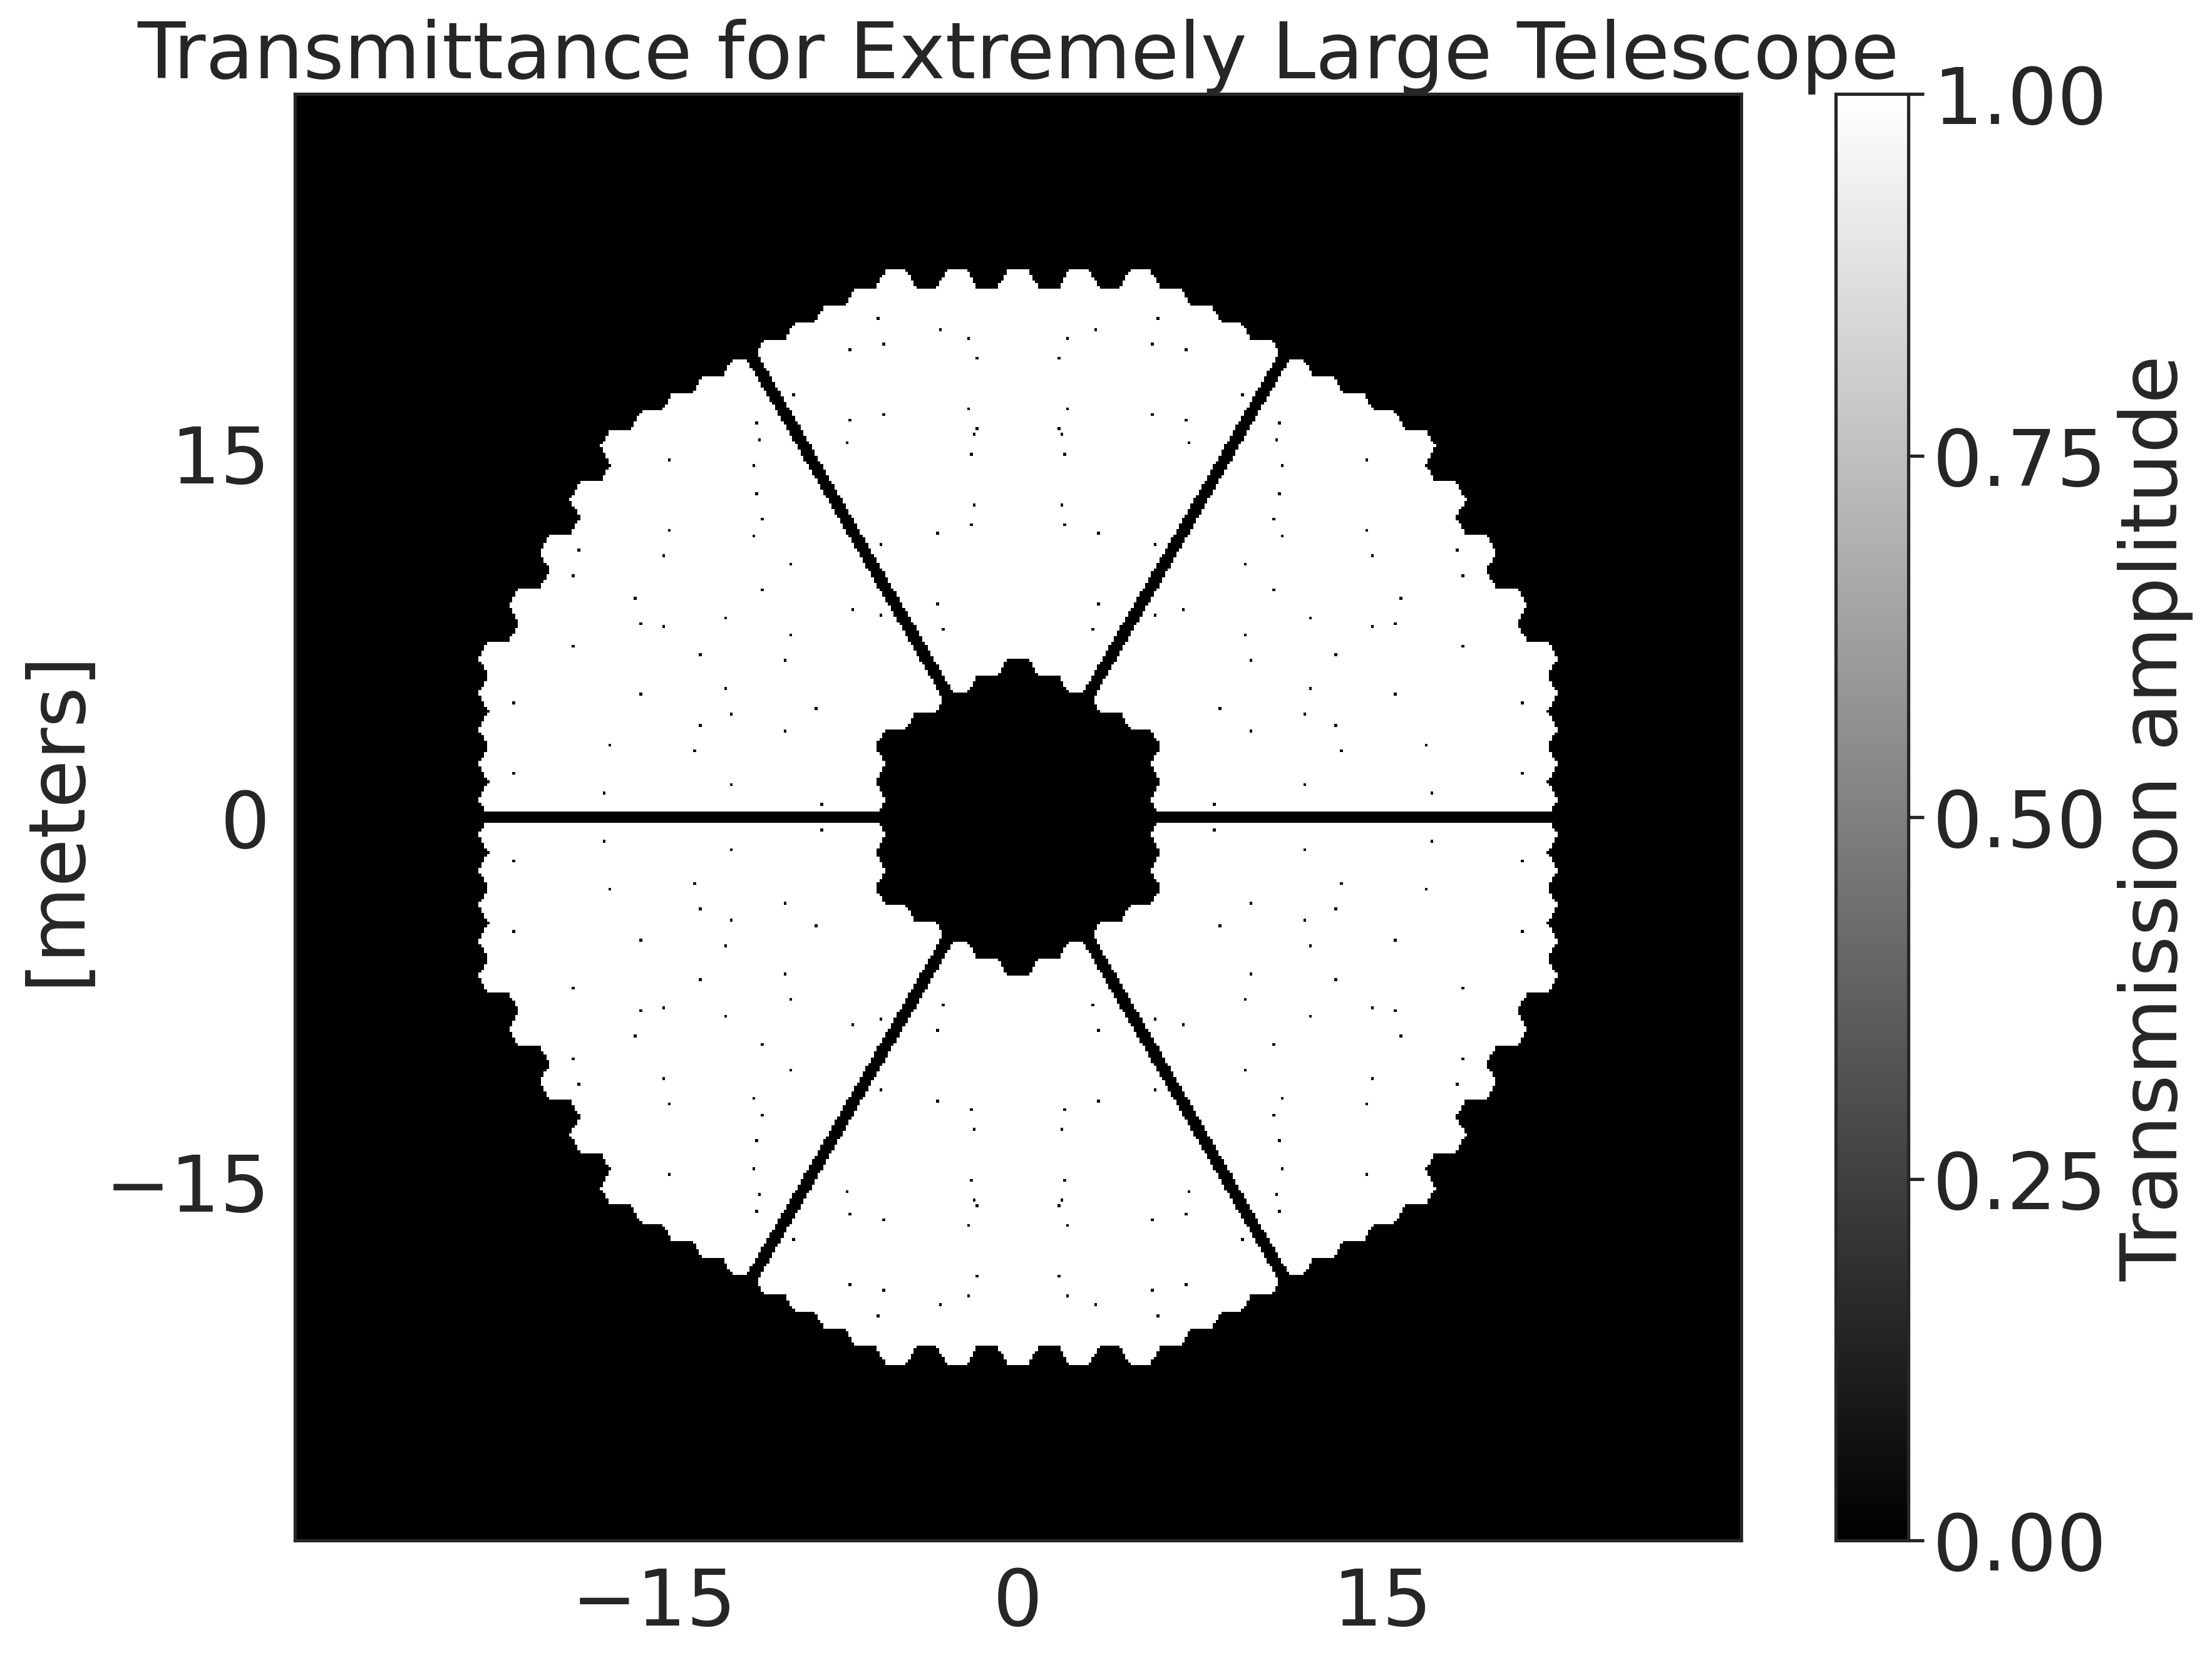

In [391]:
fig, ax = plt.subplots(figsize=(13,10))
atlast.display(npix= 512, colorbar_orientation='vertical', ax=ax)
# ax.axline((0,0),slope=0)
# ax.axline((0,0),slope=np.tan(np.pi/6))
# ax.axline((0,0),slope=np.tan(np.pi/3+np.pi/6))
# ax.axline((0,0),slope=np.tan(-np.pi/6))

# p = plt.Circle((0,0), radius =25, fill=False, linewidth=1, color='red')
# ax.add_patch(p)

# for x,y,id in zip(seg_coords[:,1], seg_coords[:,0], seg_circle):
#   ax.text(x,y, s=str(id), fontsize=5, color='red')

In [394]:
np.degrees(1.22*6000e-10/39)*3600

np.float64(0.0038714317480224238)

In [395]:
osys = poy.OpticalSystem(oversample=10)
osys.add_pupil(atlast)
osys.add_detector(pixelscale=0.005, fov_arcsec=10)


In [ ]:
psfs = 0
for wav in np.l(3500,10000,1000):
  psf = osys.calc_psf(wav*1e-10)
  psfs += psf[0].data

psf[0].data = psfs/psfs.max()

In [ ]:
psf[0].data.shape

In [ ]:
fwhm_in     = 0.01  # arcsecs
pixel_scale = 0.005  # arcseconds/pixels
FWHM        = fwhm_in/pixel_scale
sigma       = FWHM*gaussian_fwhm_to_sigma
sigma

on_axis = psfs/psfs.max()
kernel = Gaussian2DKernel(sigma,sigma,x_size=69,y_size=69)
kernel.normalize()

conv_on =  fftconvolve(on_axis, kernel, mode = 'same')
conv_on_binned = conv_on.reshape(60, 10, 60,10).sum(axis=(1,3))

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (15,15))
ax[0,0].set_title("Poppy_ON")

ax[0,0].imshow(on_axis, cmap="jet",norm=col.LogNorm())

ax[0,1].set_title("Kernel")
ax[0,1].imshow(kernel, cmap="jet")

ax[1,0].set_title("convolve_on")
im_on = ax[1,0].imshow(conv_on, cmap="jet",norm=col.LogNorm())

im_on = ax[1,1].imshow(conv_on_binned, cmap="jet",norm=col.LogNorm())
plt.colorbar(im_on,shrink=0.9)

## **6.5m Segmented Telescope**

### **Design I**

In [ ]:
pri = poy.HexSegmentedDeformableMirror(rings=2, flattoflat=1.247*u.m, gap=2.5e-3, center= False)
sec = poy.SecondaryObscuration(secondary_radius=0.6*u.m, n_supports=6, support_width=0.1)
atlast1 = poy.CompoundAnalyticOptic( opticslist=[pri, sec], name='6.5 Meter Telescope')

In [ ]:
atlast1.display(npix=1024, colorbar_orientation='vertical')

In [ ]:
osys = poy.OpticalSystem(oversample=10)
osys.add_pupil(atlast1)
osys.add_detector(pixelscale=0.1, fov_arcsec=20.1)
psf1_hdul = osys.calc_psf(5e-6)
psf1 = psf1_hdul[0].data

In [ ]:
plt.imshow(psf1, cmap='jet', norm=col.LogNorm())

In [ ]:
psf1 = psf1/psf1.sum()

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (20,10))
atlast1.display(npix=1024, colorbar_orientation='vertical', ax=ax[0])
ax[1].imshow(np.log10(psf1), cmap='jet', vmin=-10, vmax=0)

### **Design II**

In [ ]:
pri = poy.HexSegmentedDeformableMirror(rings=2, flattoflat=1.247*u.m, gap=2.5e-3, center= False)
sec = poy.SecondaryObscuration(secondary_radius=0.6*u.m, n_supports=6,
                               support_width=0.1, support_angle_offset = 90)
atlast2 = poy.CompoundAnalyticOptic( opticslist=[pri, sec], name='6.5 Meter Telescope')

In [ ]:
atlast2.display(npix=1024, colorbar_orientation='vertical')

In [ ]:
osys = poy.OpticalSystem(oversample=10)
osys.add_pupil(atlast2)
osys.add_detector(pixelscale=0.1, fov_arcsec=20.1)
psf2_hdul = osys.calc_psf(5e-6)
psf2 = psf2_hdul[0].data

In [ ]:
plt.imshow(psf2, cmap='jet', norm=col.LogNorm())

In [ ]:
psf2 = psf2/psf2.sum()

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (20,10))
atlast2.display(npix=1024, colorbar_orientation='vertical', ax=ax[0])
ax[1].imshow(np.log10(psf2), cmap='jet', vmin=-10, vmax=0)

### **Design III**

In [ ]:
pri = poy.HexSegmentedDeformableMirror(rings=2, flattoflat=1.247*u.m, gap=2.5e-3, center= False)
sec = poy.AsymmetricSecondaryObscuration(secondary_radius=0.6*u.m,
                                          support_width=0.1, support_angle=[90,150,210,270,330,390],
                                        support_offset_x  = [0,  -0.66,-0.66,0,   0.66,0.66],
                                         support_offset_y = [0.58,0,    0   ,-0.58,0,0])
atlast3 = poy.CompoundAnalyticOptic( opticslist=[pri, sec], name='6.5 Meter Telescope')

In [ ]:
atlast3.display(npix=1024, colorbar_orientation='vertical')

In [ ]:
osys = poy.OpticalSystem(oversample=10)
osys.add_pupil(atlast3)
osys.add_detector(pixelscale=0.1, fov_arcsec=20.1)
psf3_hdul = osys.calc_psf(5e-6)
psf3 = psf3_hdul[0].data

In [ ]:
plt.imshow(psf3, cmap='jet', norm=col.LogNorm())

In [ ]:
psf3 = psf3/psf3.sum()

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (20,10))
atlast3.display(npix=1024, colorbar_orientation='vertical', ax=ax[0])
ax[1].imshow(np.log10(psf3), cmap='jet', vmin=-10, vmax=0)

### **Design IV**

In [ ]:
pri = poy.CircularAperture(radius=3.25*u.meter)
sec = poy.AsymmetricSecondaryObscuration(secondary_radius=0.6*u.m,
                                          support_width=0.1, support_angle=[90,150,210,270,330,390],
                                        support_offset_x  = [-0.1 , -0.48,-0.47,0.1  ,0.47,0.47],
                                         support_offset_y = [0.54, 0.3   ,-0.3 ,-0.54,-0.3,0.3])
atlast4 = poy.CompoundAnalyticOptic( opticslist=[pri, sec], name='6.5 Meter Telescope')

In [ ]:
atlast4.display(npix=1024, colorbar_orientation='vertical')

In [ ]:
osys = poy.OpticalSystem(oversample=10)
osys.add_pupil(atlast4)
osys.add_detector(pixelscale=0.1, fov_arcsec=20.1)
psf4_hdul = osys.calc_psf(5e-6)
psf4 = psf4_hdul[0].data

In [ ]:
plt.imshow(psf4, cmap='jet', norm=col.LogNorm())

In [ ]:
psf4 = psf4/psf4.sum()

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (20,10))
atlast4.display(npix=1024, colorbar_orientation='vertical', ax=ax[0])
ax[1].imshow(np.log10(psf4), cmap='jet', vmin=-10, vmax=0)

### **Design V**

In [ ]:
pri = poy.CircularAperture(radius=3.25*u.meter)
sec = poy.AsymmetricSecondaryObscuration(secondary_radius=0.6*u.m,
                                          support_width=0.1, support_angle=[90,150,210,270,330,390])
atlast5 = poy.CompoundAnalyticOptic( opticslist=[pri, sec], name='6.5 Meter Telescope')

In [ ]:
atlast5.display(npix=1024, colorbar_orientation='vertical')

In [ ]:
osys = poy.OpticalSystem(oversample=10)
osys.add_pupil(atlast5)
osys.add_detector(pixelscale=0.1, fov_arcsec=20.1)
psf5_hdul = osys.calc_psf(5e-6)
psf5 = psf5_hdul[0].data

In [ ]:
plt.imshow(psf5, cmap='jet', norm=col.LogNorm())

In [ ]:
psf5 = psf5/psf5.sum()

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (20,10))
atlast5.display(npix=1024, colorbar_orientation='vertical', ax=ax[0])
ax[1].imshow(np.log10(psf5), cmap='jet', vmin=-10, vmax=0)

In [ ]:
poy.measure_fwhm(psf1_hdul), poy.measure_fwhm(psf2_hdul), poy.measure_fwhm(psf3_hdul),poy.measure_fwhm(psf4_hdul),poy.measure_fwhm(psf5_hdul)

In [ ]:
fwhm_in = 0.17
pixel_scale = 0.01 #arcsecond

# Input FWHM to detector fwhm conversion
fwhm = fwhm_in/pixel_scale

# fwhm to sigma conversion
sigma_psf = fwhm*gaussian_fwhm_to_sigma

# Number of pixels.
n_pix = 2010
y, x  = np.mgrid[0:(n_pix), 0:(n_pix)]

# Modelling a 2D gaussian at the center of the image.
psf_r = models.Gaussian2D(1, len(x)//2, len(x)//2, sigma_psf, sigma_psf)(x,y)

In [ ]:
psf_r = psf_r/psf_r.sum()

In [ ]:
plt.plot(psf1[900:1100,1000])
plt.plot(psf2[900:1100,1000])
plt.plot(psf3[900:1100,1000])
plt.plot(psf4[900:1100,1000])
plt.plot(psf5[900:1100,1000])
plt.plot(psf_r[901:1101,1000])
plt.legend(['Design I', 'Design II', 'Design III','Design IV','Design V','Gaussian'])
plt.xlabel('y cut')

In [ ]:
fig, ax = plt.subplots(2,5,figsize=(50,20))

atlast1.display(npix=1024, colorbar=False, ax=ax[0,0])
atlast2.display(npix=1024, colorbar=False, ax=ax[0,1])
atlast3.display(npix=1024, colorbar=False, ax=ax[0,2])
atlast4.display(npix=1024, colorbar=False, ax=ax[0,3])
atlast5.display(npix=1024, colorbar=False, ax=ax[0,4])

img = ax[1,0].imshow(np.log10(psf1), cmap='jet', vmin=-10, vmax=0)
ax[1,1].imshow(np.log10(psf2), cmap='jet', vmin=-10, vmax=0)
ax[1,2].imshow(np.log10(psf3), cmap='jet', vmin=-10, vmax=0)
ax[1,3].imshow(np.log10(psf4), cmap='jet', vmin=-10, vmax=0)
ax[1,4].imshow(np.log10(psf5), cmap='jet', vmin=-10, vmax=0)


ax[0,0].set_title('Strehl Ratio: {0:.3f}'.format(psf1.max()/psf_r.max()), fontsize=20)
ax[0,1].set_title('Strehl Ratio: {0:.3f}'.format(psf2.max()/psf_r.max()), fontsize=20)
ax[0,2].set_title('Strehl Ratio: {0:.3f}'.format(psf3.max()/psf_r.max()), fontsize=20)
ax[0,3].set_title('Strehl Ratio: {0:.3f}'.format(psf4.max()/psf_r.max()), fontsize=20)
ax[0,4].set_title('Strehl Ratio: {0:.3f}'.format(psf5.max()/psf_r.max()), fontsize=20)

ax[0,3].set_xlim(-3.3,3.3)
ax[0,3].set_ylim(-3.3,3.3)
ax[0,4].set_xlim(-3.3,3.3)
ax[0,4].set_ylim(-3.3,3.3)

fig.suptitle('6.5m Telescope Design Comparison', y = 0.93, fontsize =25)

# **Detector Simulator using pyxel**

Work in progress

In [ ]:
!pyxel download-examples

In [ ]:
psf.writeto('/content/INSIST/data/pyxel-examples/tutorial/data/source_n.fits')

In [ ]:
hdu = fits.open('/content/INSIST/data/pyxel-examples/tutorial/data/source_n.fits')

In [ ]:
data= hdu[0].data
plt.imshow(data, cmap = 'jet', norm = col.LogNorm())

In [ ]:
hdu_n = fits.PrimaryHDU(data,header = hdu[0].header)
hdul = fits.HDUList(hdu_n)
hdul.writeto('/content/INSIST/data/pyxel-examples/tutorial/data/source_m.fits',overwrite = True)

In [ ]:
with open("/content/INSIST/data/exposure_on.yaml",'r') as f:
  dat = yaml.load(f)

In [ ]:
dat

In [ ]:
dat['pipeline']['photon_generation'][0]['arguments']['image_file'] = 'data/source_m.fits'

In [ ]:
dat['pipeline']['optics'][0]['arguments']['fov_arcsec'] = 20.5

In [ ]:
dat['cmos_detector']['geometry']['row']= data.shape[0]
dat['cmos_detector']['geometry']['col']= data.shape[1]
dat['cmos_detector']['geometry']['total_thickness'] = 1 #dat['ccd_detector']['geometry']['pixel_vert_size']*dat['ccd_detector']['geometry']['row']

In [ ]:
with open("/content/INSIST/data/exposure_on.yaml", 'w') as out:
  yaml.dump(dat,out)

In [ ]:
config = pyxel.load("/content/INSIST/data/exposure_on.yaml")
exposure = config.exposure  # class Single
detector = config.cmos_detector  # class CCD
pipeline = config.pipeline  # class DetectionPipeline

In [ ]:
detector

In [ ]:
cd /content/INSIST/data/pyxel-examples/tutorial

In [ ]:
result = pyxel.exposure_mode(exposure=exposure, detector=detector, pipeline=pipeline)
result

In [ ]:
plt.imshow(result.pixel.data[0], cmap = 'jet', norm = col.LogNorm());

In [ ]:
plt.imshow(detector.photon.array, cmap = 'jet', norm = col.LogNorm());

In [ ]:
detector.__dict__

In [ ]:
detector.input_image.min()

In [ ]:
hdu_n = fits.PrimaryHDU(result.pixel.data[0],header = hdu[0].header)
hdul = fits.HDUList(hdu_n)
hdul.writeto('/content/INSIST/data/output.fits',overwrite = True)

In [ ]:
hdul[0].data.shape